In [2]:
%load_ext autoreload
%autoreload 2

In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyslim, tskit
import itertools
import scipy.special
import os, subprocess, sys
from Bio import Phylo
from io import StringIO
import msprime
import tqdm
from pathlib import Path
import statsmodels.stats.proportion
import glob
import joblib
import seaborn as sns
import scipy.ndimage

sys.path.append(str(Path(os.getcwd()).parent))

In [4]:
from src import extract_tree_stats, curve_inference, estimators, loader, tests

In [5]:
os.environ['R_HOME'] = "/home/rs2145/rs2145/software/anaconda3/envs/dated_selection/lib/R"

In [6]:
%load_ext rpy2.ipython

# Pick three regimes

In [19]:
filenames_neutral = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=-3.0/logNUd=2/seed=*/output.trees.tsz"
)

filenames_bgs = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=2.0/logNUd=2/seed=*/output.trees.tsz"
)

filenames_interference = glob.glob(
    f"/rds/project/rds-8b3VcZwY7rY/projects/dated_selection/data/paper_simulation_set_20240416/logNs=1.0/logNUd=2/seed=*/output.trees.tsz"
)


# Draw trees

# Draw mutation rate declines

In [23]:
def get_mutation_counts_and_lineages_for_ts(
    filename, 
    max_generations, 
    sample_times, 
    sample_sizes,
    n_bins,
    n_reps = 1,
    neutral_mutation_rate_per_genome = 0,
):
    all_sts = loader.load_tree_sequence_from_slim(filename, sample_sizes, sample_times, neutral_mutation_rate_per_genome, n_reps=n_reps)
    if n_reps == 1:
        all_sts = [all_sts]

    all_mut_counts_per_bin = []
    all_n_lineages_per_bin = []
    for sts in all_sts:    
        mutation_times = []
        mutation_weights = []
        for variant in sts.variants():
            for mutation in variant.site.mutations:
                mutation_times.append(mutation.time)
                mutation_weights.append(sts.num_samples - variant.counts()[''])
        
        hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
        mut_counts_per_bin = np.histogram(mutation_times, bins=hist_bins, weights=mutation_weights)[0]
    
        n_lineages = np.zeros(max_generations, dtype=int)
        for sample_time, sample_size in zip(sample_times, sample_sizes):
            n_lineages[sample_time:] += sample_size
        n_lineages_per_bin = n_lineages.reshape((n_bins, -1)).sum(axis=1)

        all_mut_counts_per_bin.append(mut_counts_per_bin)
        all_n_lineages_per_bin.append(n_lineages_per_bin)
    
    return all_mut_counts_per_bin, all_n_lineages_per_bin
    

In [24]:
def extract_mutation_rates_from_filenames(filenames):
    n_bins = 4000
    max_generations = 4000
    n_reps = 3
    hist_bins = np.linspace(0, max_generations, n_bins+1, endpoint=True)
    all_res = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(get_mutation_counts_and_lineages_for_ts)(filename, max_generations, [0], [50], n_bins, 0, n_reps) \
               for filename in filenames
    )

    #mut_counts_per_bin, n_lineages_per_bin = np.array(all_res).sum(axis=0)
    mut_counts_per_bin = np.vstack([all_mut_counts_per_bin for all_mut_counts_per_bin, all_n_lineages_per_bin in all_res]).sum(axis=0)
    n_lineages_per_bin = np.vstack([all_n_lineages_per_bin for all_mut_counts_per_bin, all_n_lineages_per_bin in all_res]).sum(axis=0)
    
    mutation_rate_est = mut_counts_per_bin / n_lineages_per_bin

    times = hist_bins[:-1]

    return times, mutation_rate_est

In [90]:
def effective_mutation_rate_theory(t, Ud, s):
    return Ud * np.exp(-s * t)

### Draw neutral

In [25]:
%%time
times_neut, mutation_rate_est_neut = extract_mutation_rates_from_filenames(filenames_neutral)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   36.3s remaining:  3.7min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   39.0s remaining:  1.8min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:   41.8s remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   44.2s remaining:   44.2s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   45.2s remaining:   27.7s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   46.9s remaining:   16.5s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   47.3s remaining:    7.7s


CPU times: user 246 ms, sys: 4.55 s, total: 4.79 s
Wall time: 48.7 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   48.5s finished


ValueError: x and y must have same first dimension, but have shapes (4000,) and (0,)

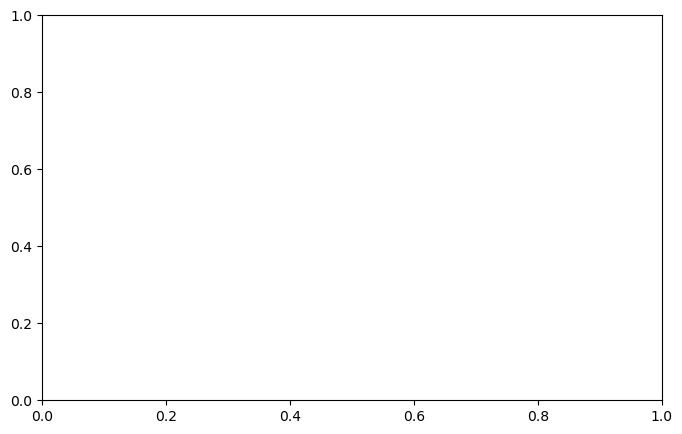

In [26]:

fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_neut, mutation_rate_est_neut, '.', ms=2, label="Data estimate");
ax.plot(times_neut, 
        scipy.ndimage.uniform_filter1d(mutation_rate_est_neut, 500, mode="nearest"), 
        '.-', ms=2, label="Smoothed (500 gens)"
);

ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-1,4000-50)
ax.set_ylim(-0.001, 0.025)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("Eff. Neutral - $Ns = 10^{-3}$");


### Draw BGS

In [62]:
%%time
times_bgs, mutation_rate_est_bgs = extract_mutation_rates_from_filenames(filenames_bgs)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   20.1s remaining:  2.1min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   20.3s remaining:   57.8s
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:   20.4s remaining:   33.2s
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:   21.5s remaining:   21.5s
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:   21.6s remaining:   13.3s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:   21.9s remaining:    7.7s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:   24.7s remaining:    4.0s


CPU times: user 234 ms, sys: 1.03 s, total: 1.27 s
Wall time: 26 s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   26.0s finished


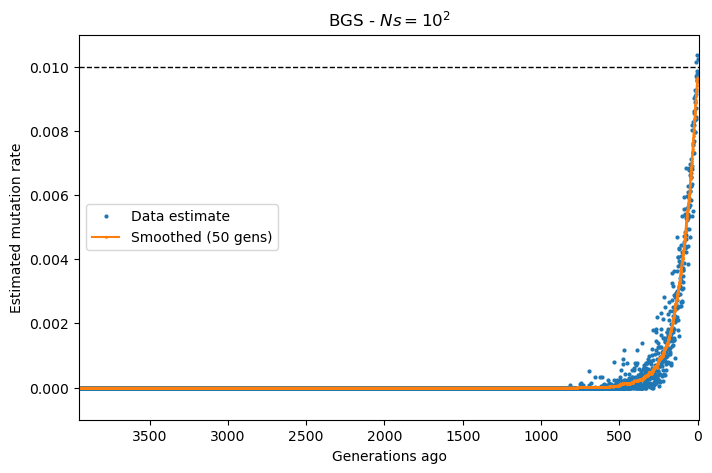

In [139]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_bgs, mutation_rate_est_bgs, '.', ms=4, label="Data estimate");
ax.plot(times_bgs, 
        scipy.ndimage.uniform_filter1d(mutation_rate_est_bgs, 50, mode="nearest"), 
        '.-', ms=2, label="Smoothed (50 gens)"
);


ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-10,4000-50)
ax.set_ylim(-0.001, 0.011)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("BGS - $Ns = 10^2}$");


### Draw interference

In [99]:
%%time
times_interference, mutation_rate_est_interference = extract_mutation_rates_from_filenames(filenames_interference)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 76 concurrent workers.
[Parallel(n_jobs=-1)]: Done   7 out of  50 | elapsed:   53.0s remaining:  5.4min
[Parallel(n_jobs=-1)]: Done  13 out of  50 | elapsed:   53.9s remaining:  2.6min
[Parallel(n_jobs=-1)]: Done  19 out of  50 | elapsed:   58.2s remaining:  1.6min
[Parallel(n_jobs=-1)]: Done  25 out of  50 | elapsed:  1.0min remaining:  1.0min
[Parallel(n_jobs=-1)]: Done  31 out of  50 | elapsed:  1.0min remaining:   37.8s
[Parallel(n_jobs=-1)]: Done  37 out of  50 | elapsed:  1.0min remaining:   21.9s
[Parallel(n_jobs=-1)]: Done  43 out of  50 | elapsed:  1.0min remaining:   10.2s


CPU times: user 272 ms, sys: 1.25 s, total: 1.52 s
Wall time: 1min 4s


[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


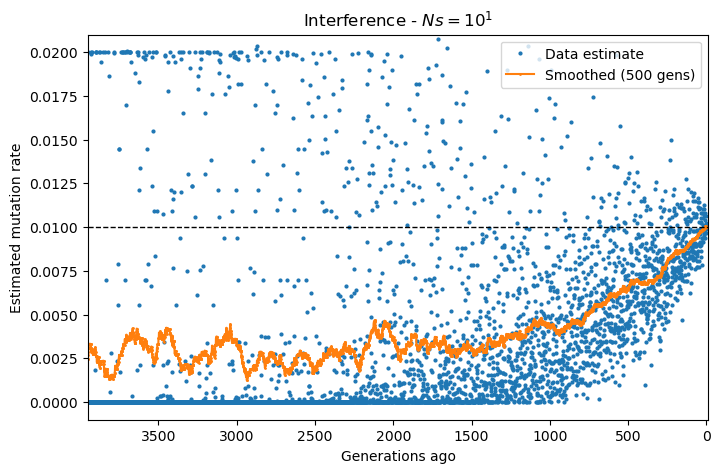

In [105]:
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(times_interference, mutation_rate_est_interference, '.', ms=4, label="Data estimate");

ax.plot(times_interference, 
        scipy.ndimage.uniform_filter1d(mutation_rate_est_interference, 100, mode="nearest"), 
        '.-', ms=2, label="Smoothed (500 gens)"
);

ax.axhline(0.01, ls='--', lw=1, color="black")
ax.set_xlim(-10,4000-50)
ax.set_ylim(-0.001, 0.021)
ax.set_xlabel("Generations ago")
ax.set_ylabel(r"Estimated mutation rate")
ax.legend()
ax.invert_xaxis()
ax.set_title("Interference - $Ns = 10^{1}$");


# Draw skyline plots

### Draw neutral

In [20]:
n_reps = 10

newick_filenames_neutral = []
for ts_filename in tqdm.tqdm(filenames_neutral):
    all_ts = loader.load_tree_sequence_from_slim(
        ts_filename,
        [50],
        [0],
        0.0,
        random_seed = 42,
        recapitate = True,
        recapitate_Ne = 10000,
        n_reps = n_reps,
    )

    for n_subrep, ts in zip(range(n_reps), all_ts):
        newick_filename = ts_filename.replace(".trees.tsz", f".n_rep={n_subrep}.newick")    
        if os.path.exists(newick_filename):
            newick_filenames_neutral.append(newick_filename)
        else:                
            T = ts.first().split_polytomies(random_seed=42)
            if len(T.roots) == 1: 
                with open(newick_filename, "w") as F:
                    F.write(T.as_newick())
                    newick_filenames_neutral.append(newick_filename)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:57<00:00, 19.16s/it]


In [21]:
%%R -i newick_filenames_neutral -o combined_popsize_neutral
# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
# > install.packages("foreach", repos='http://cran.us.r-project.org')
# > install.packages("doParallel", repos='http://cran.us.r-project.org')
require("ape")
require("foreach")
require("doParallel")

# Register parallel backend
cl <- makeCluster(50)
registerDoParallel(cl)

# Explicitly export necessary functions and packages to parallel workers
clusterEvalQ(cl, {
  require(ape)
})

# Define a function to process each newick file
process_newick_file <- function(filename) {
    tr <- read.tree(file=filename)
    mcmc.out <- mcmc.popsize(tr, 10000, thinning=10, burn.in=1000)
    return(extract.popsize(mcmc.out))
}

# Use foreach to parallelize the processing of filenames
popsize_list <- foreach(filename = newick_filenames_neutral) %dopar% {
    #process_newick_file(filename)
    tryCatch({
        process_newick_file(filename)
    }, error = function(e) {
        message("Error occurred: ", conditionMessage(e))
        NULL  # Return NULL if an error occurs
    })
}

# Stop the parallel backend
stopCluster(cl)

first_matrix <- popsize_list[[1]]
dimensions <- dim(first_matrix)

# The columns are "time" "mean" "median" "lower CI", "Upper CI"
combined_popsize_neutral <- array(unlist(popsize_list), dim = c(dimensions[1], dimensions[2], length(popsize_list)))


Text(0.5, 1.0, 'Eff. neutral (averaged across 500 reps, n=50 tips)')

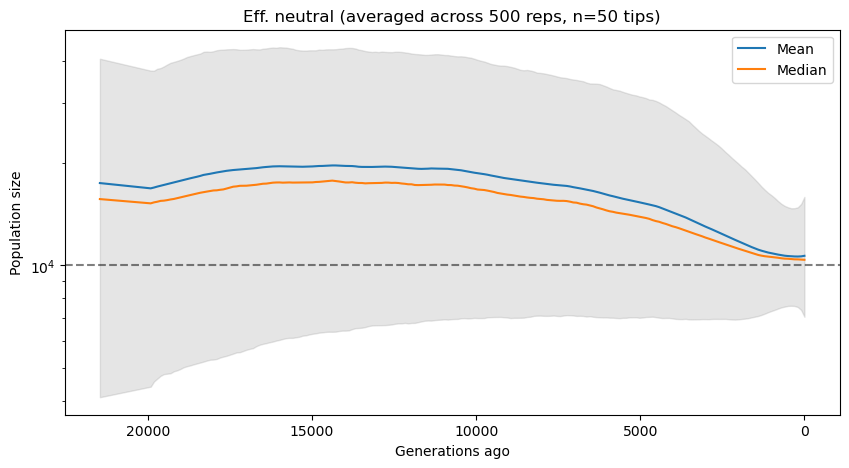

In [22]:
fig, ax = plt.subplots(figsize=(10, 5))
times = np.nanmean(combined_popsize_neutral[:,0,:], axis=1)
ax.plot(times, np.nanmean(combined_popsize_neutral[:,1,:], axis=1), label="Mean");
ax.plot(times, np.nanmean(combined_popsize_neutral[:,2,:], axis=1), label="Median");
ax.fill_between(
    times, 
    np.nanmean(combined_popsize_neutral[:,3,:], axis=1),
    np.nanmean(combined_popsize_neutral[:,4,:], axis=1),
    color="gray", 
    alpha=0.2,
)

ax.legend();
ax.set_xlabel("Generations ago");
ax.set_ylabel("Population size");
ax.set_yscale("log")
ax.invert_xaxis()
ax.axhline(10000, color="black", ls="--", alpha=0.5);
ax.set_title("Eff. neutral (averaged across 500 reps, n=50 tips)")

### Draw BGS

In [78]:
newick_filenames_bgs = []
for ts_filename in tqdm.tqdm(filenames_bgs):
    newick_filename = ts_filename.replace(".trees.tsz", ".newick")    
    if False: #os.path.exists(newick_filename):
        newick_filenames_bgs.append(newick_filename)
    else:    
        ts = loader.load_tree_sequence_from_slim(
            ts_filename,
            [100],
            [0],
            0.0,
        )
        T = ts.first().split_polytomies(random_seed=42)
        if len(T.roots) == 1: #, f"# roots = {len(T.roots)}"
            with open(newick_filename, "w") as F:
                F.write(T.as_newick())
                newick_filenames_bgs.append(newick_filename)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [04:51<00:00,  5.84s/it]


In [79]:
%%R -i newick_filenames_bgs -o combined_popsize_bgs
# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
# > install.packages("foreach", repos='http://cran.us.r-project.org')
# > install.packages("doParallel", repos='http://cran.us.r-project.org')
require("ape")
require("foreach")
require("doParallel")

# Register parallel backend
cl <- makeCluster(50)
registerDoParallel(cl)

# Explicitly export necessary functions and packages to parallel workers
clusterEvalQ(cl, {
  require(ape)
})

# Define a function to process each newick file
process_newick_file <- function(filename) {
    tr <- read.tree(file=filename)
    mcmc.out <- mcmc.popsize(tr, 10000, thinning=10, burn.in=1000)
    return(extract.popsize(mcmc.out))
}

# Use foreach to parallelize the processing of filenames
popsize_list <- foreach(filename = newick_filenames_bgs) %dopar% {
    #process_newick_file(filename)
    tryCatch({
        process_newick_file(filename)
    }, error = function(e) {
        message("Error occurred: ", conditionMessage(e))
        NULL  # Return NULL if an error occurs
    })
}

# Stop the parallel backend
stopCluster(cl)

first_matrix <- popsize_list[[1]]
dimensions <- dim(first_matrix)

# The columns are "time" "mean" "median" "lower CI", "Upper CI"
combined_popsize_bgs <- array(unlist(popsize_list), dim = c(dimensions[1], dimensions[2], length(popsize_list)))


Text(0.5, 1.0, 'BGS (averaged across 50 reps)')

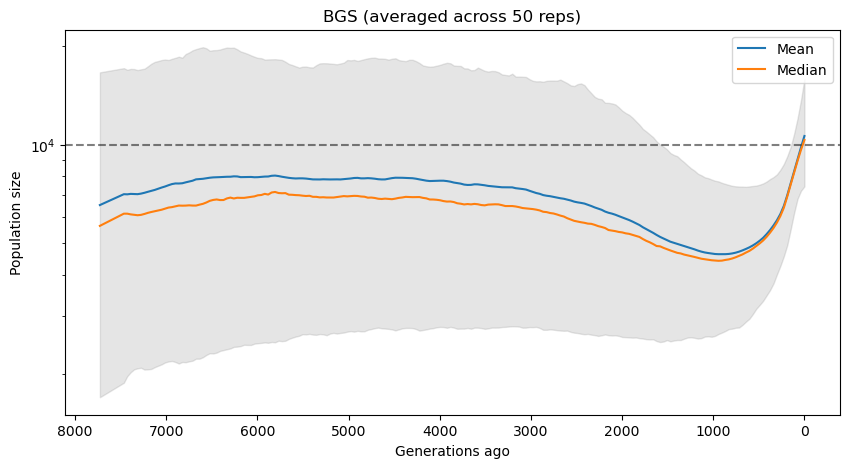

In [80]:
fig, ax = plt.subplots(figsize=(10, 5))
times = np.nanmean(combined_popsize_bgs[:,0,:], axis=1)
ax.plot(times, np.nanmean(combined_popsize_bgs[:,1,:], axis=1), label="Mean");
ax.plot(times, np.nanmean(combined_popsize_bgs[:,2,:], axis=1), label="Median");
ax.fill_between(
    times, 
    np.nanmean(combined_popsize_bgs[:,3,:], axis=1),
    np.nanmean(combined_popsize_bgs[:,4,:], axis=1),
    color="gray", 
    alpha=0.2,
)

ax.legend();
ax.set_xlabel("Generations ago");
ax.set_ylabel("Population size");
ax.set_yscale("log")
#ax.legend(fontsize=14)
#ax.set_ylim(1000,50000)
#ax.set_xticks([0,500,1000,1500,2000,2500])
#ax.tick_params(axis='both', which='major', labelsize=15)
ax.invert_xaxis()
ax.axhline(10000, color="black", ls="--", alpha=0.5);
ax.set_title("BGS (averaged across 50 reps)")

### Draw interference

In [81]:
newick_filenames_interference = []
for ts_filename in tqdm.tqdm(filenames_interference):
    newick_filename = ts_filename.replace(".trees.tsz", ".newick")    
    if False: #os.path.exists(newick_filename):
        newick_filenames_interference.append(newick_filename)
    else:    
        ts = loader.load_tree_sequence_from_slim(
            ts_filename,
            [100],
            [0],
            0.0,
        )
        T = ts.first().split_polytomies(random_seed=42)
        if len(T.roots) == 1: #, f"# roots = {len(T.roots)}"
            with open(newick_filename, "w") as F:
                F.write(T.as_newick())
                newick_filenames_interference.append(newick_filename)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [06:14<00:00,  7.49s/it]


In [82]:
%%R -i newick_filenames_interference -o combined_popsize_interference
# Open the conda-installed R in terminal:
# > install.packages("ape", repos='http://cran.us.r-project.org')
# > install.packages("foreach", repos='http://cran.us.r-project.org')
# > install.packages("doParallel", repos='http://cran.us.r-project.org')
require("ape")
require("foreach")
require("doParallel")

# Register parallel backend
cl <- makeCluster(50)
registerDoParallel(cl)

# Explicitly export necessary functions and packages to parallel workers
clusterEvalQ(cl, {
  require(ape)
})

# Define a function to process each newick file
process_newick_file <- function(filename) {
    tr <- read.tree(file=filename)
    mcmc.out <- mcmc.popsize(tr, 10000, thinning=10, burn.in=1000)
    return(extract.popsize(mcmc.out))
}

# Use foreach to parallelize the processing of filenames
popsize_list <- foreach(filename = newick_filenames_interference) %dopar% {
    #process_newick_file(filename)
    tryCatch({
        process_newick_file(filename)
    }, error = function(e) {
        message("Error occurred: ", conditionMessage(e))
        NULL  # Return NULL if an error occurs
    })
}

# Stop the parallel backend
stopCluster(cl)

first_matrix <- popsize_list[[1]]
dimensions <- dim(first_matrix)

# The columns are "time" "mean" "median" "lower CI", "Upper CI"
combined_popsize_interference <- array(unlist(popsize_list), dim = c(dimensions[1], dimensions[2], length(popsize_list)))


Text(0.5, 1.0, 'Interference (averaged across 50 reps)')

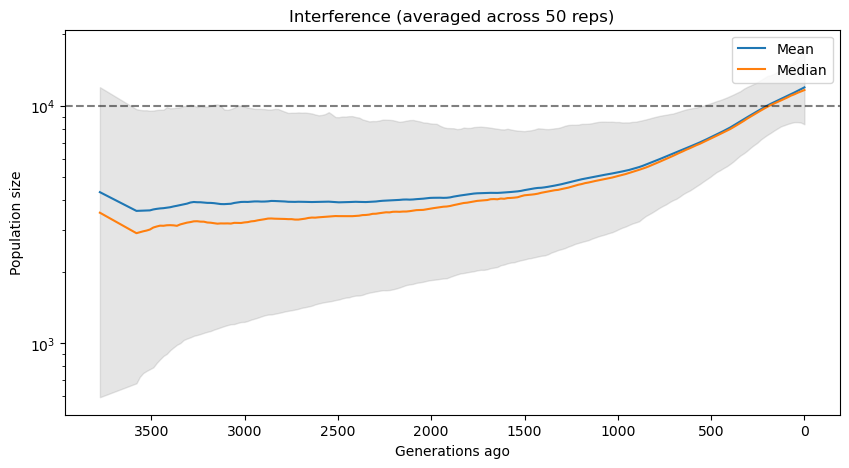

In [83]:
fig, ax = plt.subplots(figsize=(10, 5))
times = np.nanmean(combined_popsize_interference[:,0,:], axis=1)
ax.plot(times, np.nanmean(combined_popsize_interference[:,1,:], axis=1), label="Mean");
ax.plot(times, np.nanmean(combined_popsize_interference[:,2,:], axis=1), label="Median");
ax.fill_between(
    times, 
    np.nanmean(combined_popsize_interference[:,3,:], axis=1),
    np.nanmean(combined_popsize_interference[:,4,:], axis=1),
    color="gray", 
    alpha=0.2,
)

ax.legend();
ax.set_xlabel("Generations ago");
ax.set_ylabel("Population size");
ax.set_yscale("log")
#ax.legend(fontsize=14)
#ax.set_ylim(1000,50000)
#ax.set_xticks([0,500,1000,1500,2000,2500])
#ax.tick_params(axis='both', which='major', labelsize=15)
ax.invert_xaxis()
ax.axhline(10000, color="black", ls="--", alpha=0.5);
ax.set_title("Interference (averaged across 50 reps)")